In [1]:
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import multinomial
from scipy.stats import dirichlet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

### Binomial

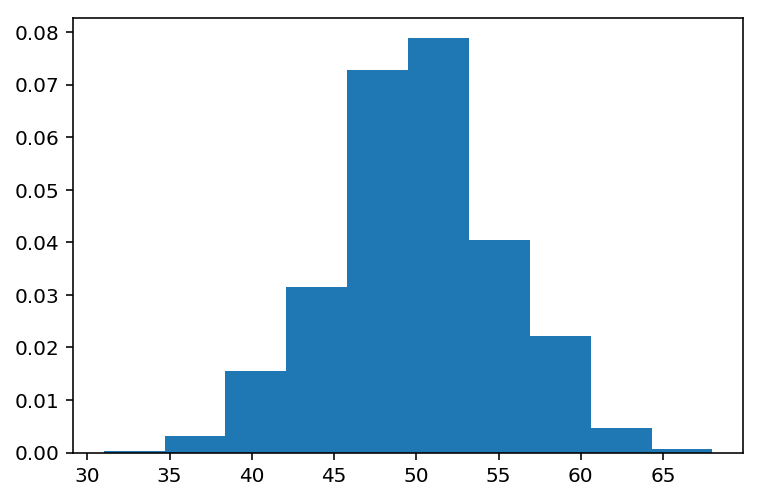

In [2]:
plt.hist(binom.rvs(n= 100, 
          p = 0.5, 
          size=5000), density = True, bins = 10);

# samples from a Binomial(n, p) are number of successes

### Beta

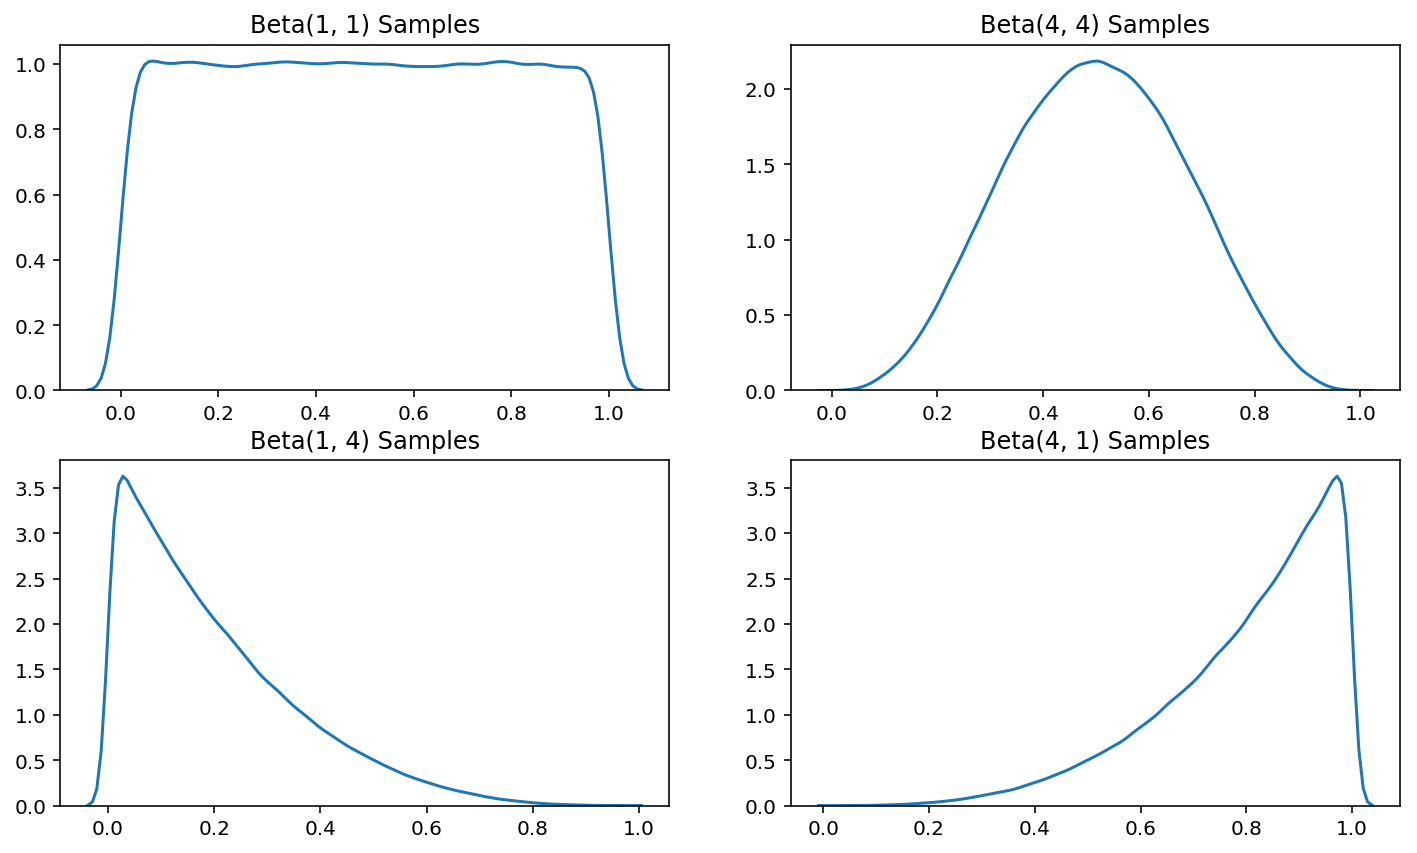

In [3]:
n = int(5e5) # number of samples
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

sns.distplot(beta.rvs(1, 1, size = n), 
             hist = False,
             ax = ax[0, 0]).set_title("Beta(1, 1) Samples")

sns.distplot(beta.rvs(4, 4, size = n), 
             hist = False,
             ax = ax[0, 1]).set_title("Beta(4, 4) Samples")

sns.distplot(beta.rvs(1, 4, size = n), 
             hist = False,
             ax = ax[1, 0]).set_title("Beta(1, 4) Samples")

sns.distplot(beta.rvs(4, 1, size = n), 
             hist = False,
             ax = ax[1, 1]).set_title("Beta(4, 1) Samples");

# samples from Beta(a, b) are probabilities

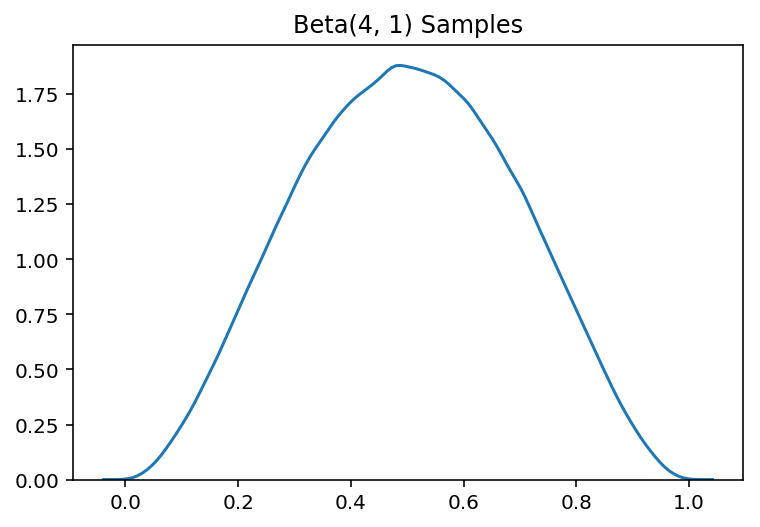

In [13]:
sns.distplot(beta.rvs(3, 3, size = n), 
             hist = False).set_title("Beta(4, 1) Samples");

### Multinomial

In [ ]:
multinomial.rvs(n=100, p=[0.25, 0.75], size = 5)

# samples from a multinomial are success counts for each outcome

### Dirichlet

In [ ]:
dirich_samples = pd.DataFrame(dirichlet.rvs(alpha = [1, 5, 15], size = 10000))

fig = plt.figure(figsize = (12, 7))
sns.distplot(dirich_samples[0], 
             kde_kws = {"label": "Alpha = 0.4"}, 
             color = "teal",
             hist = False,
             #norm_hist = True,
             kde = True)
sns.distplot(dirich_samples[1], 
             kde_kws = {"label": "Alpha = 5"}, 
             color = "blue",
             hist = False,
             #norm_hist = True,
             kde = True);
sns.distplot(dirich_samples[2], 
             kde_kws = {"label": "Alpha = 15"}, 
             color = "red",
             hist = False,
             #norm_hist = True,
             kde = True);
plt.title("Samples from a Dirichlet Distribution");

# dirichlet is to multinomial as beta is to binomial.
# samples from a dirichlet distribution are realizations of the probabilities for a multinomial distribution

## Inference on Stick Breaking Example - Pyro

In [2]:
import torch
from torch.distributions import constraints
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from pyro.distributions import *
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
assert pyro.__version__.startswith('1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)

#### Synthetic Mixture of Gaussians

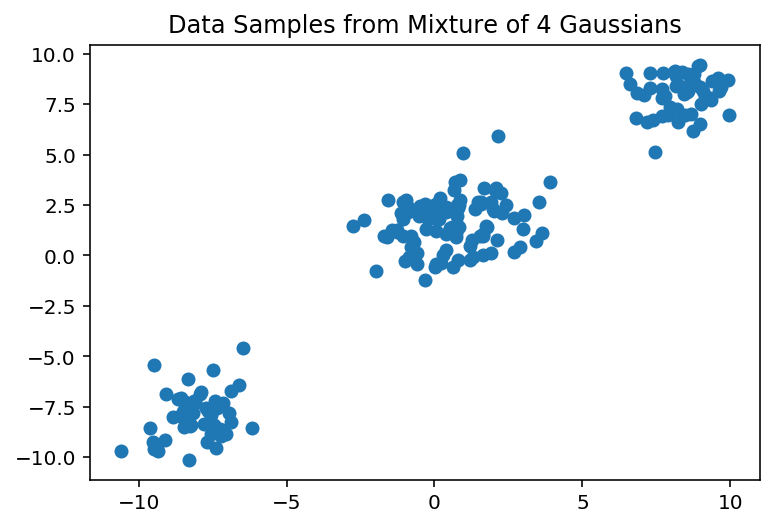

In [3]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0];

In this example, the cluster parameters 𝜃𝑖 are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution 𝐺0 is also a multivariate Gaussian (i.e. the conjugate prior), although this choice is not as computationally useful, since we are not performing coordinate-ascent variational inference but rather black-box variational inference using Pyro.

First, let’s define the “stick-breaking” function that generates our weights, given our samples of 𝛽:

In [4]:
# first sample beta from Beta(1, \alpha)
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

Note that all 𝛽𝑖 samples are conditionally independent, so we model them using a `pyro.plate` of size `T-1`; we do the same for all samples of our cluster parameters 𝜇𝑖.   
We then construct a Categorical distribution whose parameters are the mixture weights using our sampled 𝛽 values (line 9) below, and sample the cluster assignment 𝑧𝑛 for each data point from that Categorical.   
Finally, we sample our observations from a multivariate Gaussian distribution whose mean is exactly the cluster parameter corresponding to the assignment 𝑧𝑛 we drew for the point 𝑥𝑛. This can be seen in the Pyro code below:

In [5]:
def model(data):
    # sample beta_i
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))
    
    # sample cluster parameter, mu_i
    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))
    
    with pyro.plate("data", N):
        # categorical dist whose params are the mixture weights from sampled beta
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        # sample obs from multivariate gaussian whose mean is the cluster param corresponding to the assignment 
        # z_n drew for the point x_n
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [6]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

100%|██████████| 1000/1000 [00:12<00:00, 78.63it/s]


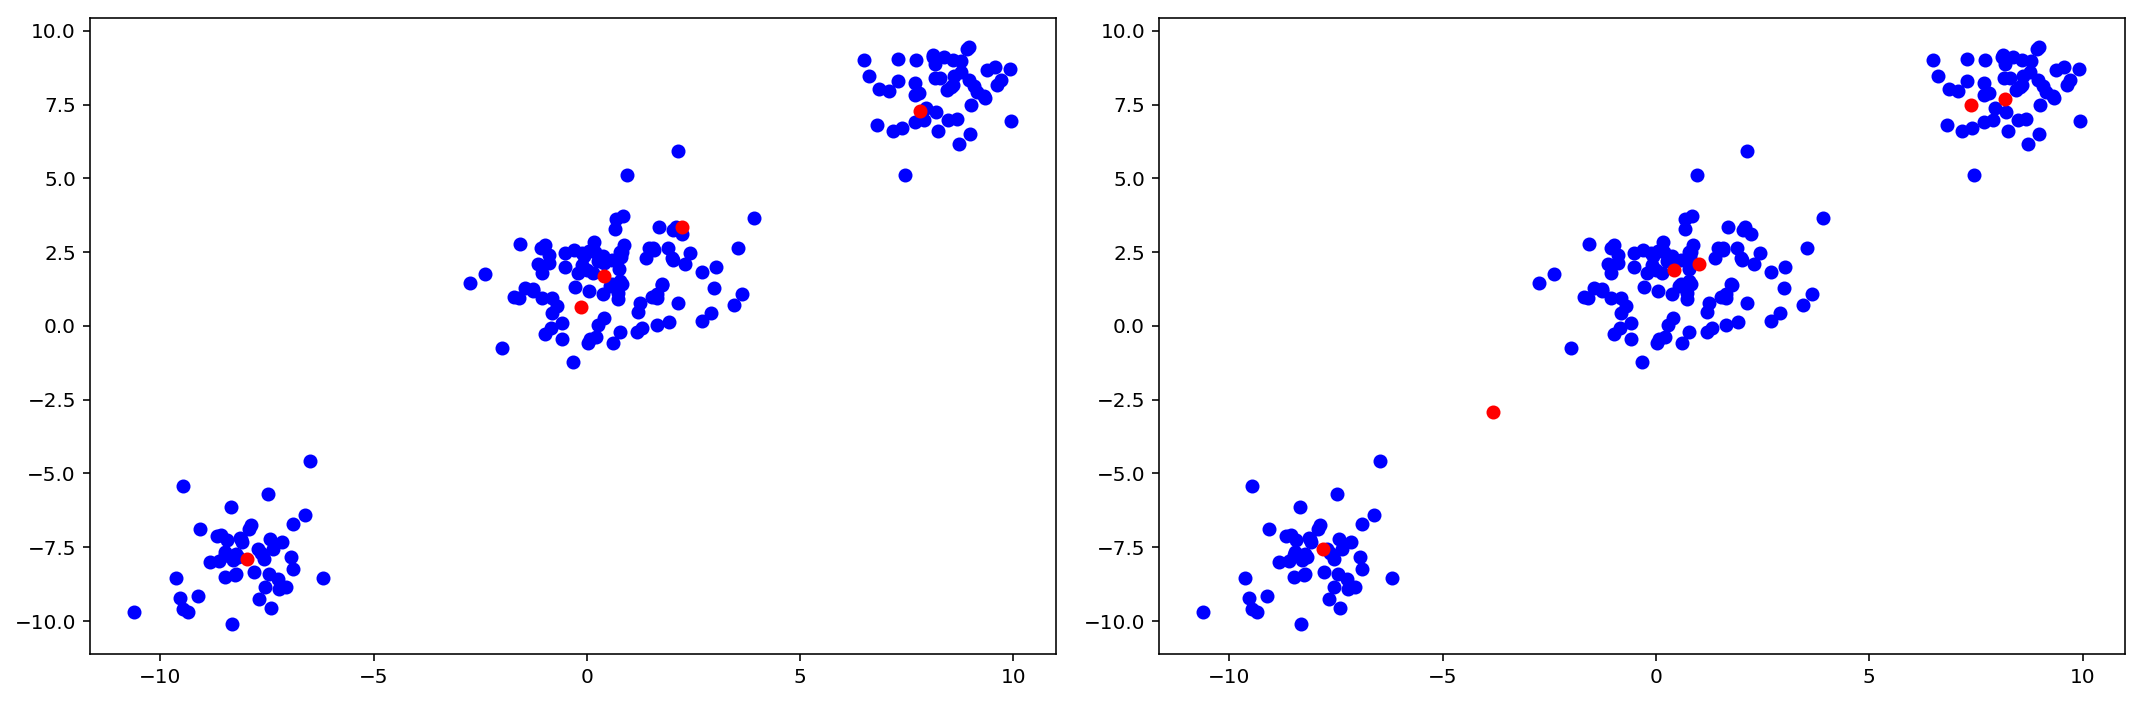

In [7]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show();

## Dirichlet Mixture Model for Long-term Solar Observations

As mentioned earlier, the Dirichlet process mixture model truly shines when exploring a dataset whose latent geometric structure is completely unknown. To demonstrate this, we fit a DPMM on sunspot count data taken over the past 300 years (provided by the Royal Observatory of Belgium):

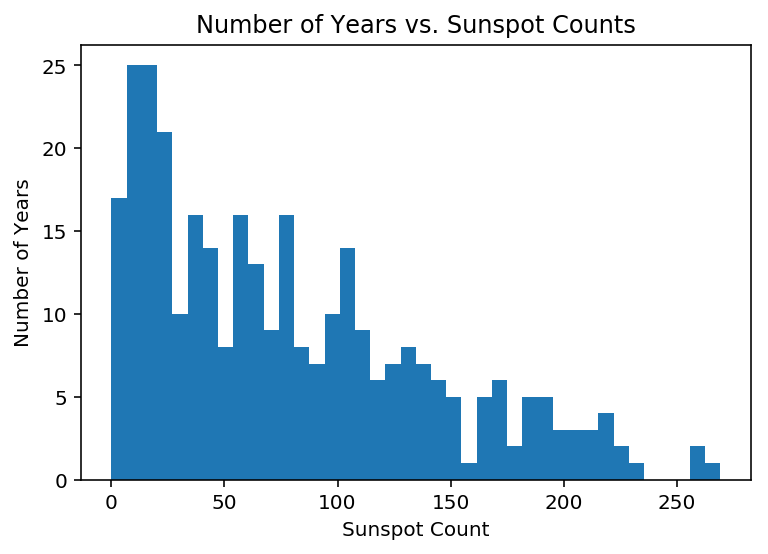

In [8]:
df = pd.read_csv('http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.csv', sep=';', 
                 names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show();

For this example, the cluster parameters 𝜃𝑖 are rate parameters since we are constructing a scale-mixture of Poisson distributions. Again, 𝐺0 is chosen to be the conjugate prior, which in this case is a Gamma distribution, though this still does not strictly matter for doing inference through Pyro. Below is the implementation of the model:

In [9]:
pyro.enable_validation(False)

# first sample beta from Beta(1, \alpha)
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
        lmbda = pyro.sample("lambda", Gamma(3, 0.05))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', lambda: Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', lambda: LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))
        
def mixture_of_poisson(weights, rates, samples):
    return (weights * Poisson(rates).log_prob(samples.unsqueeze(-1)).exp()).sum(-1)

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

100%|██████████| 1500/1500 [00:06<00:00, 229.61it/s]


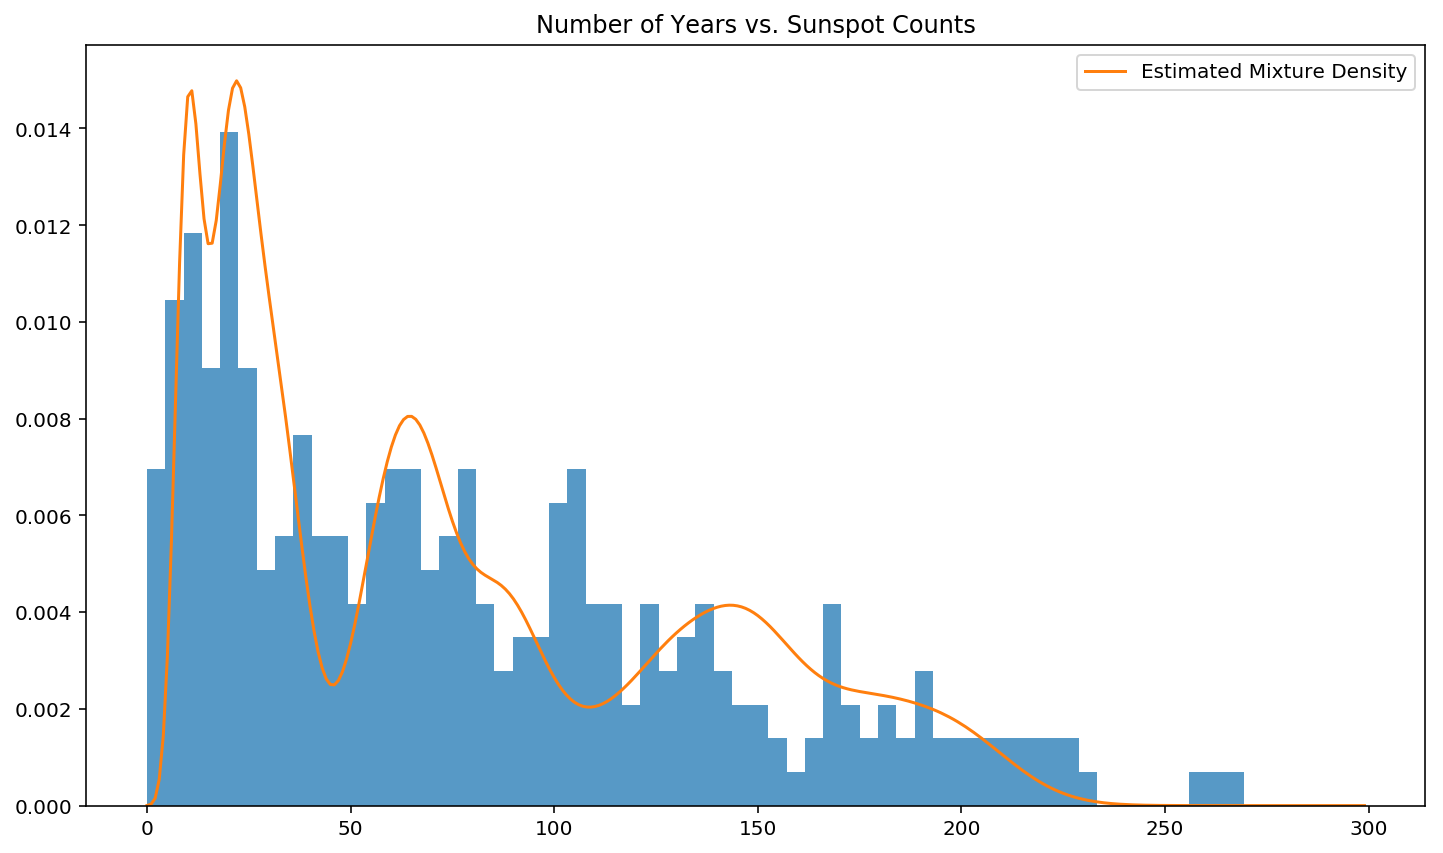

In [12]:
T = 20
alpha = 1.1
n_iter = 1500
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

train(n_iter)

samples = torch.arange(0, 300).type(torch.float)

tau0_optimal = pyro.param("tau_0").detach()
tau1_optimal = pyro.param("tau_1").detach()
kappa_optimal = pyro.param("kappa").detach()

# We make a point-estimate of our latent variables using the posterior means of tau and kappa for the cluster params and weights
Bayes_Rates = (tau0_optimal / tau1_optimal)
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.figure(figsize=(12, 7))
plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show();